In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Load the dataset
print("=" * 80)
print("LOADING HDB RESALE DATA")
print("=" * 80)
df = pd.read_csv('HDB resale 2024.csv')

print(f"\nDataset loaded successfully!")
print(f"Total records: {len(df)}")
print(f"Total columns: {len(df.columns)}")
print(f"\nColumn names: {list(df.columns)}")

LOADING HDB RESALE DATA

Dataset loaded successfully!
Total records: 12127
Total columns: 10

Column names: ['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range', 'floor_area_sqm', 'lease_commence_date', 'remaining_lease', 'resale_price']


This comprehensive solution:
1.Loads and inspects the HDB resale data
2.Detects and handles missing values by removing rows with missing resale prices
3.Removes duplicates to ensure data quality
4.Converts data types appropriately (datetime, numeric)
5.Engineers new features (remaining lease in months, property age, storey midpoint)
6.Detects outliers using IQR method
7.Validates data for logical consistency
8.Provides statistical summaries for all columns
9.Saves cleaned data to CSV file
10.Creates visualizations using Seaborn (distributions, correlations, comparisons)
11.Builds regression models (Linear Regression and Random Forest) to predict resale prices

In [2]:
# ============================================================================
# STEP 1: INITIAL DATA INSPECTION
# ============================================================================

print("\n" + "=" * 80)
print("STEP 1: INITIAL DATA INSPECTION")
print("=" * 80)

# Display first few rows
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Display basic information
print("\n\nDataset Information:")
print(df.info())

# Display basic statistics
print("\n\nBasic Statistics:")
print(df.describe())

# Check data types
print("\n\nData Types:")
print(df.dtypes)


STEP 1: INITIAL DATA INSPECTION

First 5 rows of the dataset:
     month        town flat_type block       street_name storey_range  \
0  2024-01  ANG MO KIO         2   116  ANG MO KIO AVE 4     07 TO 09   
1  2024-01  ANG MO KIO         2   510  ANG MO KIO AVE 8     04 TO 06   
2  2024-01  ANG MO KIO         3  308B  ANG MO KIO AVE 1     01 TO 03   
3  2024-01  ANG MO KIO         3  308B  ANG MO KIO AVE 1     25 TO 27   
4  2024-01  ANG MO KIO         3   223  ANG MO KIO AVE 1     04 TO 06   

   floor_area_sqm lease_commence_date     remaining_lease resale_price  
0            44.0                1978  53 years 06 months       288000  
1            44.0                1980  55 years 07 months       322500  
2            70.0                2012  87 years 09 months       520000  
3            70.0                2012  87 years 09 months       650000  
4            67.0                1978   53 years 01 month       343800  


Dataset Information:
<class 'pandas.core.frame.DataFrame'>

In [3]:
# ============================================================================
# STEP 2: MISSING VALUES DETECTION AND HANDLING
# ============================================================================

print("\n" + "=" * 80)
print("STEP 2: MISSING VALUES DETECTION")
print("=" * 80)

# Check for missing values
missing_values = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100

missing_df = pd.DataFrame({
    'Column': missing_values.index,
    'Missing_Count': missing_values.values,
    'Missing_Percentage': missing_percentage.values
})

print("\nMissing Values Summary:")
print(missing_df[missing_df['Missing_Count'] > 0])

# Store original row count
original_count = len(df)

# Remove rows with missing resale_price (critical column)
df = df.dropna(subset=['resale_price'])

print(f"\nRows removed due to missing resale_price: {original_count - len(df)}")
print(f"Remaining rows: {len(df)}")


STEP 2: MISSING VALUES DETECTION

Missing Values Summary:
                Column  Missing_Count  Missing_Percentage
1                 town              4            0.032984
2            flat_type              1            0.008246
3                block              1            0.008246
4          street_name              2            0.016492
5         storey_range              1            0.008246
7  lease_commence_date              4            0.032984
9         resale_price              7            0.057722

Rows removed due to missing resale_price: 7
Remaining rows: 12120


In [4]:
# ============================================================================
# STEP 3: DUPLICATE DETECTION AND REMOVAL
# ============================================================================

print("\n" + "=" * 80)
print("STEP 3: DUPLICATE DETECTION")
print("=" * 80)

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")

if duplicates > 0:
    df = df.drop_duplicates()
    print(f"Duplicate rows removed: {duplicates}")
    print(f"Remaining rows: {len(df)}")


STEP 3: DUPLICATE DETECTION

Number of duplicate rows: 24
Duplicate rows removed: 24
Remaining rows: 12096


In [5]:
# ============================================================================
# STEP 4: DATA TYPE CONVERSION AND VALIDATION
# ============================================================================

print("\n" + "=" * 80)
print("STEP 4: DATA TYPE CONVERSION")
print("=" * 80)

# Convert month to datetime
df['month'] = pd.to_datetime(df['month'], format='%Y-%m')
print("\n✓ Converted 'month' to datetime format")

# Ensure numeric columns are properly typed
df['floor_area_sqm'] = pd.to_numeric(df['floor_area_sqm'], errors='coerce')
df['lease_commence_date'] = pd.to_numeric(df['lease_commence_date'], errors='coerce')
df['resale_price'] = pd.to_numeric(df['resale_price'], errors='coerce')

print("✓ Converted numeric columns to appropriate types")

# Remove any rows that became NaN after conversion
before_clean = len(df)
df = df.dropna(subset=['floor_area_sqm', 'lease_commence_date', 'resale_price'])
after_clean = len(df)

if before_clean > after_clean:
    print(f"✓ Removed {before_clean - after_clean} rows with invalid numeric values")


STEP 4: DATA TYPE CONVERSION

✓ Converted 'month' to datetime format
✓ Converted numeric columns to appropriate types
✓ Removed 21 rows with invalid numeric values


In [6]:
# ============================================================================
# STEP 5: FEATURE ENGINEERING - REMAINING LEASE PARSING
# ============================================================================

print("\n" + "=" * 80)
print("STEP 5: FEATURE ENGINEERING")
print("=" * 80)

def parse_remaining_lease(lease_str):
    """
    Parse remaining lease string to extract total months
    Example: "53 years 06 months" -> 636 months
    """
    if pd.isna(lease_str):
        return np.nan
    
    years = 0
    months = 0
    
    # Extract years
    if 'year' in str(lease_str):
        try:
            years = int(str(lease_str).split('year')[0].strip())
        except:
            pass
    
    # Extract months
    if 'month' in str(lease_str):
        try:
            month_part = str(lease_str).split('year')[-1]
            months = int(month_part.split('month')[0].strip())
        except:
            pass
    
    return years * 12 + months

# Apply the parsing function
df['remaining_lease_months'] = df['remaining_lease'].apply(parse_remaining_lease)
print("✓ Created 'remaining_lease_months' feature")

# Calculate property age
current_year = 2024
df['property_age'] = current_year - df['lease_commence_date']
print("✓ Created 'property_age' feature")

# Extract storey midpoint
def extract_storey_midpoint(storey_range):
    """Extract midpoint of storey range"""
    if pd.isna(storey_range):
        return np.nan
    try:
        parts = str(storey_range).split('TO')
        if len(parts) == 2:
            lower = int(parts[0].strip())
            upper = int(parts[1].strip())
            return (lower + upper) / 2
    except:
        return np.nan
    return np.nan

df['storey_midpoint'] = df['storey_range'].apply(extract_storey_midpoint)
print("✓ Created 'storey_midpoint' feature")


STEP 5: FEATURE ENGINEERING
✓ Created 'remaining_lease_months' feature
✓ Created 'property_age' feature
✓ Created 'storey_midpoint' feature


In [7]:
# ============================================================================
# STEP 6: OUTLIER DETECTION AND HANDLING
# ============================================================================

print("\n" + "=" * 80)
print("STEP 6: OUTLIER DETECTION")
print("=" * 80)

# Check for outliers in resale_price using IQR method
Q1 = df['resale_price'].quantile(0.25)
Q3 = df['resale_price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 3 * IQR  # Using 3*IQR for less aggressive outlier removal
upper_bound = Q3 + 3 * IQR

outliers_price = df[(df['resale_price'] < lower_bound) | (df['resale_price'] > upper_bound)]
print(f"\nOutliers in resale_price: {len(outliers_price)}")
print(f"Lower bound: ${lower_bound:,.0f}")
print(f"Upper bound: ${upper_bound:,.0f}")

# Check for outliers in floor_area_sqm
Q1_area = df['floor_area_sqm'].quantile(0.25)
Q3_area = df['floor_area_sqm'].quantile(0.75)
IQR_area = Q3_area - Q1_area

lower_bound_area = Q1_area - 3 * IQR_area
upper_bound_area = Q3_area + 3 * IQR_area

outliers_area = df[(df['floor_area_sqm'] < lower_bound_area) | (df['floor_area_sqm'] > upper_bound_area)]
print(f"\nOutliers in floor_area_sqm: {len(outliers_area)}")

# Note: We keep outliers as they may represent legitimate luxury properties
print("\n✓ Outliers identified but retained (may represent luxury properties)")


STEP 6: OUTLIER DETECTION

Outliers in resale_price: 19
Lower bound: $-217,500
Upper bound: $1,375,000

Outliers in floor_area_sqm: 0

✓ Outliers identified but retained (may represent luxury properties)


In [8]:
# ============================================================================
# STEP 7: DATA VALIDATION
# ============================================================================

print("\n" + "=" * 80)
print("STEP 7: DATA VALIDATION")
print("=" * 80)

# Validate positive values
invalid_price = df[df['resale_price'] <= 0]
invalid_area = df[df['floor_area_sqm'] <= 0]
invalid_age = df[df['property_age'] < 0]

print(f"\nInvalid resale_price (<=0): {len(invalid_price)}")
print(f"Invalid floor_area_sqm (<=0): {len(invalid_area)}")
print(f"Invalid property_age (<0): {len(invalid_age)}")

# Remove invalid entries
before_validation = len(df)
df = df[(df['resale_price'] > 0) & (df['floor_area_sqm'] > 0) & (df['property_age'] >= 0)]
after_validation = len(df)

if before_validation > after_validation:
    print(f"\n✓ Removed {before_validation - after_validation} rows with invalid values")


STEP 7: DATA VALIDATION

Invalid resale_price (<=0): 0
Invalid floor_area_sqm (<=0): 0
Invalid property_age (<0): 0


In [9]:
# ============================================================================
# STEP 8: STATISTICAL SUMMARY
# ============================================================================

print("\n" + "=" * 80)
print("STEP 8: STATISTICAL SUMMARY")
print("=" * 80)

# Summary statistics for numeric columns
print("\n--- Numeric Columns Summary ---")
numeric_summary = df[['resale_price', 'floor_area_sqm', 'property_age', 
                      'remaining_lease_months', 'storey_midpoint']].describe()
print(numeric_summary)

# Summary for categorical columns
print("\n--- Categorical Columns Summary ---")

print(f"\nTown Distribution:")
town_counts = df['town'].value_counts()
print(town_counts)

print(f"\n\nFlat Type Distribution:")
flat_type_counts = df['flat_type'].value_counts()
print(flat_type_counts)

print(f"\n\nAverage Resale Price by Town:")
avg_price_by_town = df.groupby('town')['resale_price'].mean().sort_values(ascending=False)
print(avg_price_by_town)

print(f"\n\nAverage Resale Price by Flat Type:")
avg_price_by_type = df.groupby('flat_type')['resale_price'].mean().sort_values(ascending=False)
print(avg_price_by_type)


STEP 8: STATISTICAL SUMMARY

--- Numeric Columns Summary ---
       resale_price  floor_area_sqm  property_age  remaining_lease_months  \
count  1.207500e+04    12075.000000  12075.000000            12075.000000   
mean   5.941593e+05       95.356745     25.845880              876.333913   
std    1.821109e+05       24.026996     15.180735              182.679498   
min    2.300000e+05       31.000000      4.000000                0.000000   
25%    4.650000e+05       74.000000      9.000000              720.000000   
50%    5.700000e+05       93.000000     26.000000              864.000000   
75%    6.925000e+05      111.000000     39.000000             1080.000000   
max    1.588000e+06      208.000000     58.000000             1140.000000   

       storey_midpoint  
count     12066.000000  
mean          8.650920  
std           5.767219  
min           2.000000  
25%           5.000000  
50%           8.000000  
75%          11.000000  
max          47.000000  

--- Categorical Co

In [10]:
# ============================================================================
# STEP 9: SAVE CLEANED DATA
# ============================================================================

print("\n" + "=" * 80)
print("STEP 9: SAVING CLEANED DATA")
print("=" * 80)

# Save cleaned dataset
output_file = 'HDB_resale_cleaned.csv'
df.to_csv(output_file, index=False)

print(f"\n✓ Cleaned data saved to '{output_file}'")
print(f"✓ Total records in cleaned dataset: {len(df)}")
print(f"✓ Total columns: {len(df.columns)}")


STEP 9: SAVING CLEANED DATA

✓ Cleaned data saved to 'HDB_resale_cleaned.csv'
✓ Total records in cleaned dataset: 12075
✓ Total columns: 13



STEP 10: DATA VISUALIZATION


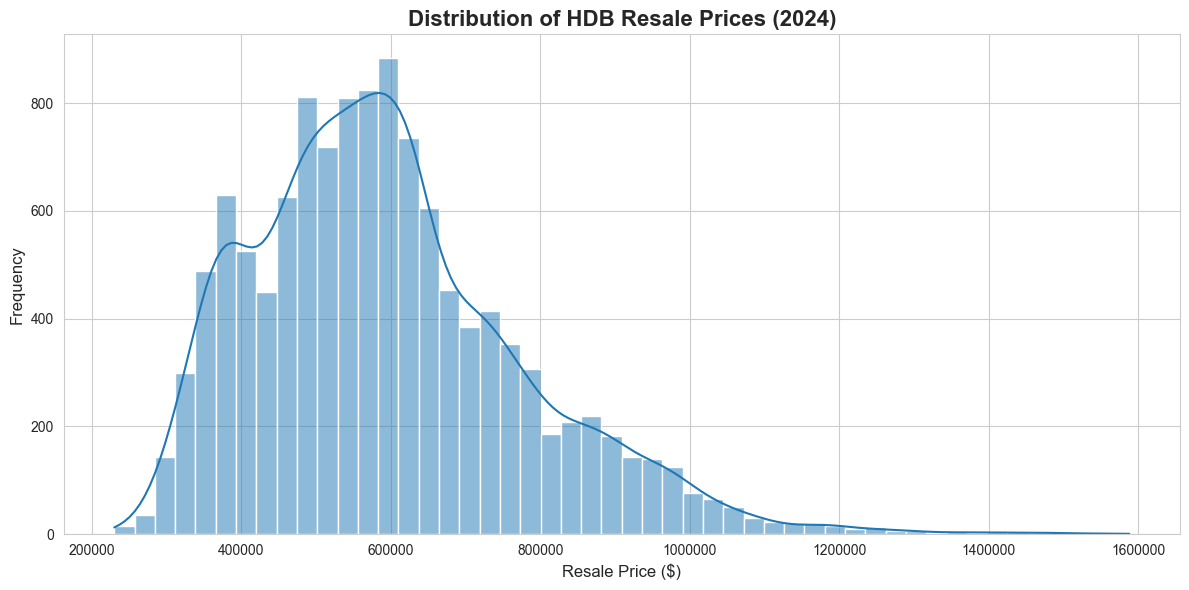

✓ Saved: resale_price_distribution.png


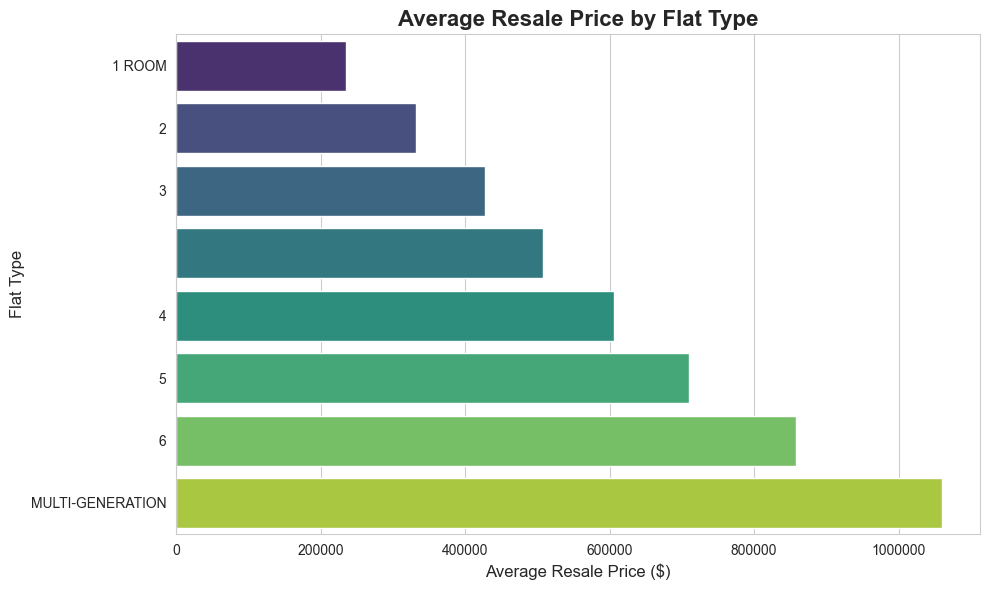

✓ Saved: price_by_flat_type.png


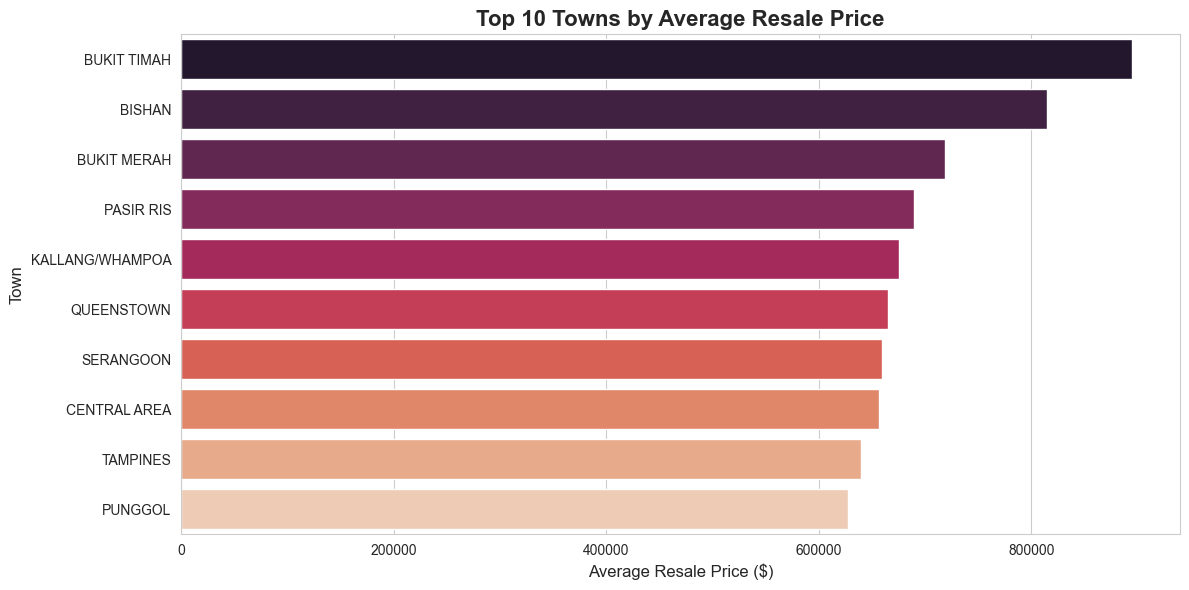

✓ Saved: top_towns_price.png


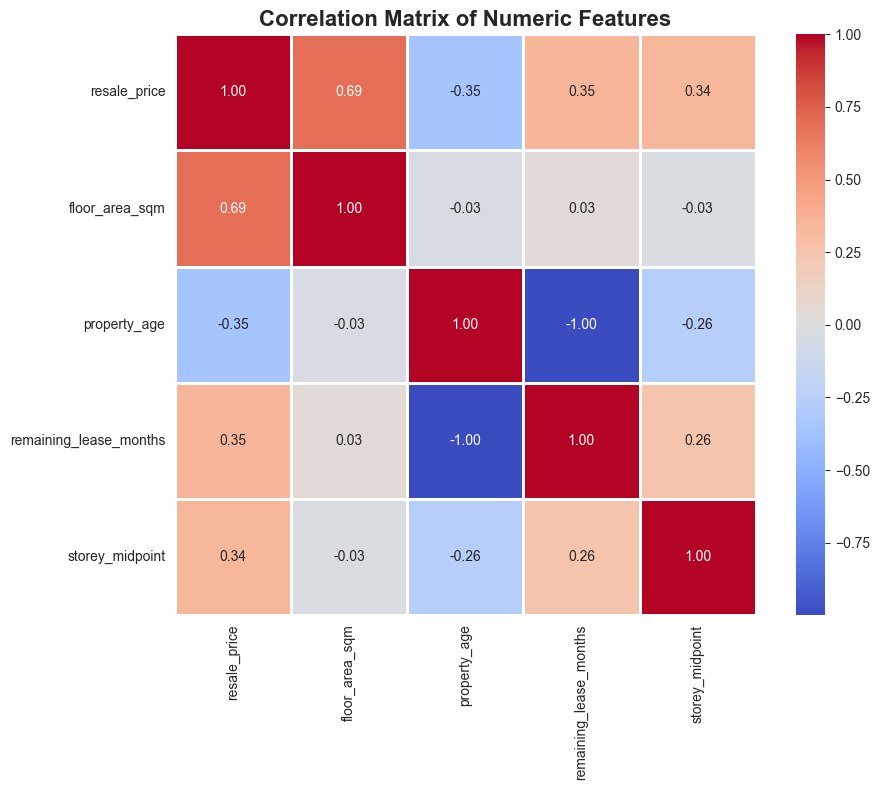

✓ Saved: correlation_heatmap.png


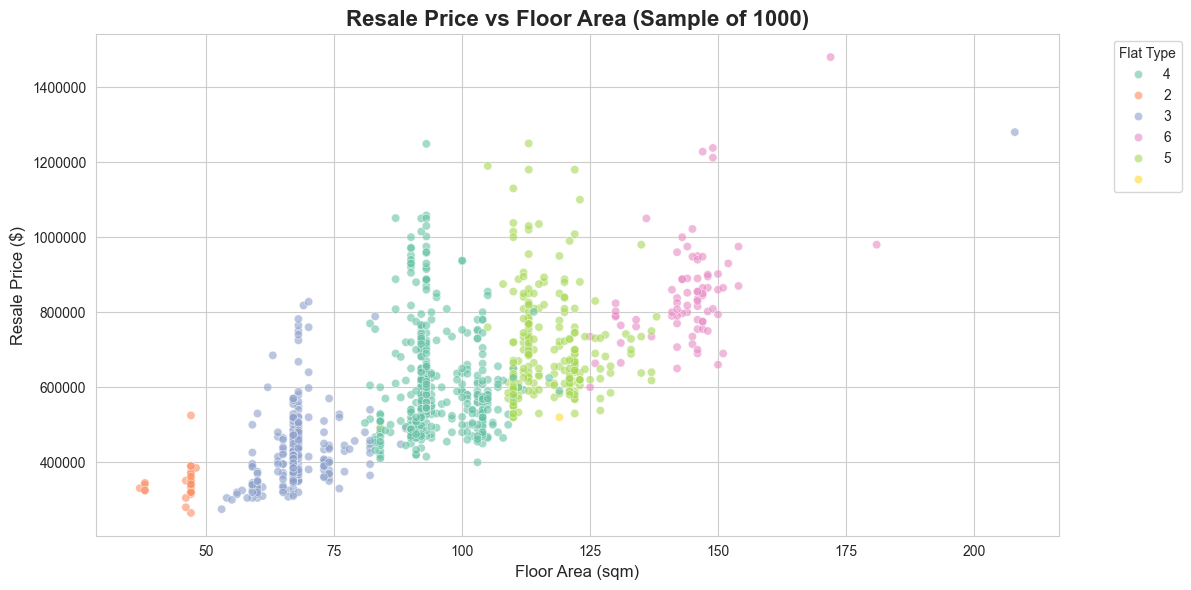

✓ Saved: price_vs_area.png


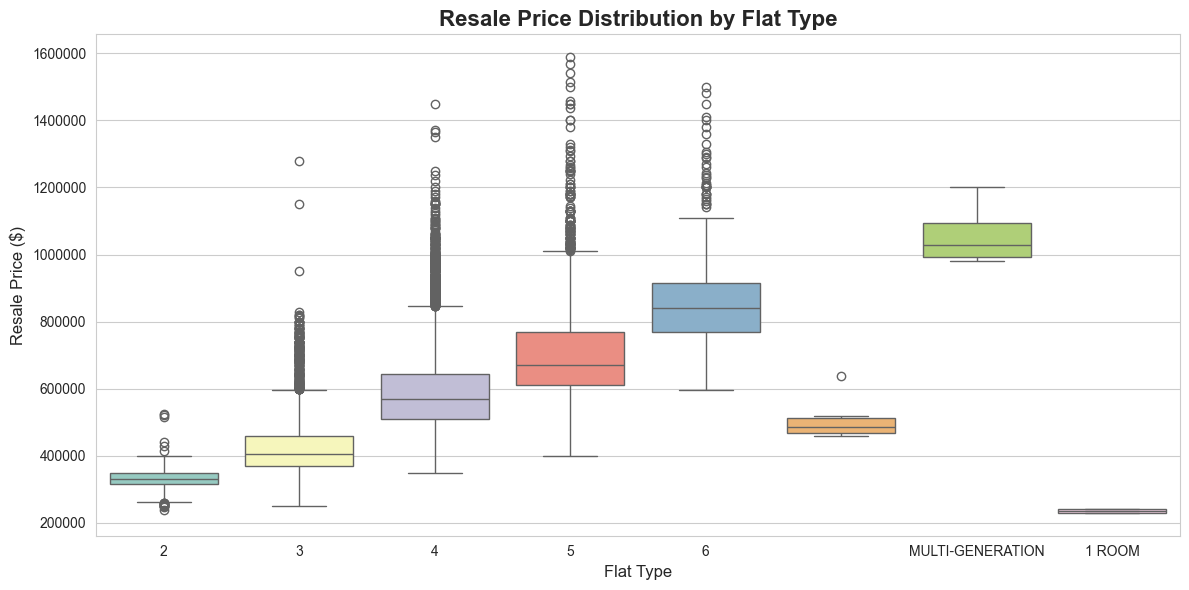

✓ Saved: price_boxplot_by_type.png


In [11]:
# ============================================================================
# STEP 10: DATA VISUALIZATION USING SEABORN
# ============================================================================

print("\n" + "=" * 80)
print("STEP 10: DATA VISUALIZATION")
print("=" * 80)

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# 1. Distribution of Resale Prices
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='resale_price', bins=50, kde=True)
plt.title('Distribution of HDB Resale Prices (2024)', fontsize=16, fontweight='bold')
plt.xlabel('Resale Price ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.ticklabel_format(style='plain', axis='x')
plt.tight_layout()
plt.savefig('resale_price_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: resale_price_distribution.png")

# 2. Average Resale Price by Flat Type
plt.figure(figsize=(10, 6))
avg_price_type = df.groupby('flat_type')['resale_price'].mean().sort_values()
sns.barplot(x=avg_price_type.values, y=avg_price_type.index, palette='viridis')
plt.title('Average Resale Price by Flat Type', fontsize=16, fontweight='bold')
plt.xlabel('Average Resale Price ($)', fontsize=12)
plt.ylabel('Flat Type', fontsize=12)
plt.ticklabel_format(style='plain', axis='x')
plt.tight_layout()
plt.savefig('price_by_flat_type.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: price_by_flat_type.png")

# 3. Top 10 Towns by Average Resale Price
plt.figure(figsize=(12, 6))
top_towns = df.groupby('town')['resale_price'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=top_towns.values, y=top_towns.index, palette='rocket')
plt.title('Top 10 Towns by Average Resale Price', fontsize=16, fontweight='bold')
plt.xlabel('Average Resale Price ($)', fontsize=12)
plt.ylabel('Town', fontsize=12)
plt.ticklabel_format(style='plain', axis='x')
plt.tight_layout()
plt.savefig('top_towns_price.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: top_towns_price.png")

# 4. Correlation Heatmap
plt.figure(figsize=(10, 8))
correlation_cols = ['resale_price', 'floor_area_sqm', 'property_age', 
                    'remaining_lease_months', 'storey_midpoint']
correlation_matrix = df[correlation_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, fmt='.2f')
plt.title('Correlation Matrix of Numeric Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: correlation_heatmap.png")

# 5. Resale Price vs Floor Area
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df.sample(1000), x='floor_area_sqm', y='resale_price', 
                hue='flat_type', alpha=0.6, palette='Set2')
plt.title('Resale Price vs Floor Area (Sample of 1000)', fontsize=16, fontweight='bold')
plt.xlabel('Floor Area (sqm)', fontsize=12)
plt.ylabel('Resale Price ($)', fontsize=12)
plt.legend(title='Flat Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.savefig('price_vs_area.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: price_vs_area.png")

# 6. Box plot of prices by flat type
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='flat_type', y='resale_price', palette='Set3')
plt.title('Resale Price Distribution by Flat Type', fontsize=16, fontweight='bold')
plt.xlabel('Flat Type', fontsize=12)
plt.ylabel('Resale Price ($)', fontsize=12)
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('price_boxplot_by_type.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: price_boxplot_by_type.png")


STEP 11: BUILDING REGRESSION MODEL

Training set size: 9660
Test set size: 2415
Number of features: 36

--- Linear Regression Model ---
RMSE: $68,755.36
R² Score: 0.8701

--- Random Forest Regression Model ---
RMSE: $51,279.88
R² Score: 0.9277

--- Top 10 Most Important Features ---
               feature  importance
        floor_area_sqm    0.560726
       storey_midpoint    0.105063
          property_age    0.075967
remaining_lease_months    0.044328
      town_BUKIT MERAH    0.028868
           town_BISHAN    0.019828
  town_KALLANG/WHAMPOA    0.017485
       town_QUEENSTOWN    0.016088
        town_TOA PAYOH    0.012263
         town_SENGKANG    0.010563


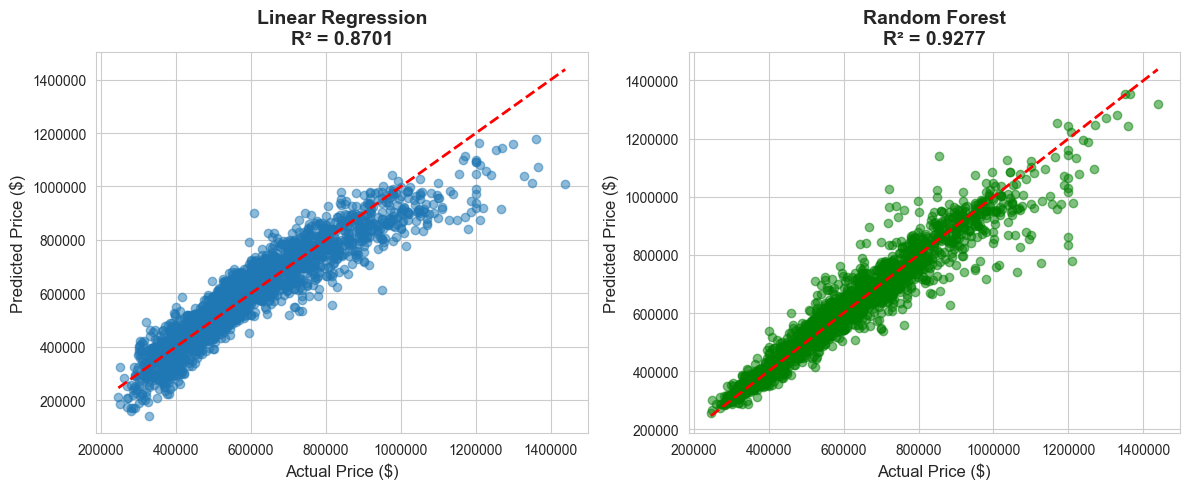


✓ Saved: model_predictions.png

ANALYSIS COMPLETE!

Cleaned dataset: HDB_resale_cleaned.csv (12075 records)
Visualizations saved: 7 PNG files
Best model: Random Forest (R² = 0.9277)


In [12]:
# ============================================================================
# STEP 11 (OPTIONAL): REGRESSION MODEL FOR PRICE PREDICTION
# ============================================================================

print("\n" + "=" * 80)
print("STEP 11: BUILDING REGRESSION MODEL")
print("=" * 80)

# Prepare data for modeling
# Select features for prediction
feature_columns = ['floor_area_sqm', 'property_age', 'remaining_lease_months', 'storey_midpoint']

# Create dummy variables for categorical features
df_model = df.copy()
df_model = pd.get_dummies(df_model, columns=['town', 'flat_type'], drop_first=True)

# Select features (all dummy variables + numeric features)
X_columns = [col for col in df_model.columns if col.startswith('town_') or 
             col.startswith('flat_type_') or col in feature_columns]

X = df_model[X_columns].fillna(0)
y = df_model['resale_price']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Number of features: {len(X_columns)}")

# Model 1: Linear Regression
print("\n--- Linear Regression Model ---")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)

lr_mse = mean_squared_error(y_test, lr_predictions)
lr_rmse = np.sqrt(lr_mse)
lr_r2 = r2_score(y_test, lr_predictions)

print(f"RMSE: ${lr_rmse:,.2f}")
print(f"R² Score: {lr_r2:.4f}")

# Model 2: Random Forest Regression
print("\n--- Random Forest Regression Model ---")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

rf_mse = mean_squared_error(y_test, rf_predictions)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, rf_predictions)

print(f"RMSE: ${rf_rmse:,.2f}")
print(f"R² Score: {rf_r2:.4f}")

# Feature importance from Random Forest
print("\n--- Top 10 Most Important Features ---")
feature_importance = pd.DataFrame({
    'feature': X_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).head(10)

print(feature_importance.to_string(index=False))

# Visualize predictions vs actual
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, lr_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price ($)', fontsize=12)
plt.ylabel('Predicted Price ($)', fontsize=12)
plt.title(f'Linear Regression\nR² = {lr_r2:.4f}', fontsize=14, fontweight='bold')
plt.ticklabel_format(style='plain')

plt.subplot(1, 2, 2)
plt.scatter(y_test, rf_predictions, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price ($)', fontsize=12)
plt.ylabel('Predicted Price ($)', fontsize=12)
plt.title(f'Random Forest\nR² = {rf_r2:.4f}', fontsize=14, fontweight='bold')
plt.ticklabel_format(style='plain')

plt.tight_layout()
plt.savefig('model_predictions.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n✓ Saved: model_predictions.png")

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE!")
print("=" * 80)
print(f"\nCleaned dataset: HDB_resale_cleaned.csv ({len(df)} records)")
print(f"Visualizations saved: 7 PNG files")
print(f"Best model: Random Forest (R² = {rf_r2:.4f})")